In [10]:
library(readr)
library(Rtsne)
library(dplyr)
library(GGally)
library(repr)
library(e1071)
library(caret)

# Reading Data

In [3]:
#### Reading lactamase filtered sequences as data frame ####
nat.raw = read_csv("Data/P450/P450_filtered.csv", col_names = F)
nat = data.frame(do.call(rbind, strsplit(nat.raw$X1, "")))
rm(nat.raw)

#### Reading positive and negative engineered lactamase sequences ####
# Reading all engineered sequences
eng.raw = read_csv("Data/P450/P450_seqs.csv", col_names = F)
eng = data.frame(do.call(rbind, strsplit(eng.raw$X1, "")))
rm(eng.raw)

# Getting labels
positives = read_csv("Data/P450/P450_func.csv", col_names = FALSE)$X1
positives = as.logical(positives)

Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_integer()
)


## Processing

In [4]:
# Splitting engineered to negatvie and positive
eng.pos = eng[positives, ]
eng.neg = eng[!positives, ]

#### Combining Data ####
nat.sub = sample_n(nat, size = 2500)
comb = rbind(eng.pos, eng.neg, nat.sub)
labels = as.factor(c(rep("Positive", nrow(eng.pos)), rep("Negative", nrow(eng.neg)), rep("Natural", nrow(nat.sub))))
colors = c(rep(1, nrow(eng.pos)), rep(2, nrow(eng.neg)), rep(3, nrow(nat.sub)))

# t-SNE

[S. Rauschka's basic intro to t-SNE.](https://github.com/rasbt/stat479-machine-learning-fs18/blob/master/14_feat-extract/14_feat-extract_slides.pdf)

**Idea: Map nearby points on a manifold in the original space to a near position in the low dimensional space.**

1. Measure Euclidean distance matrix in high dimension and convert to probability of picking point as neighbor using a Gaussian density for each point.
2. Do "same as 1. in low dimension but with t-Distribution"
3. Minimize KL-divergence between the two matrices

In [7]:
tsne = Rtsne(comb)

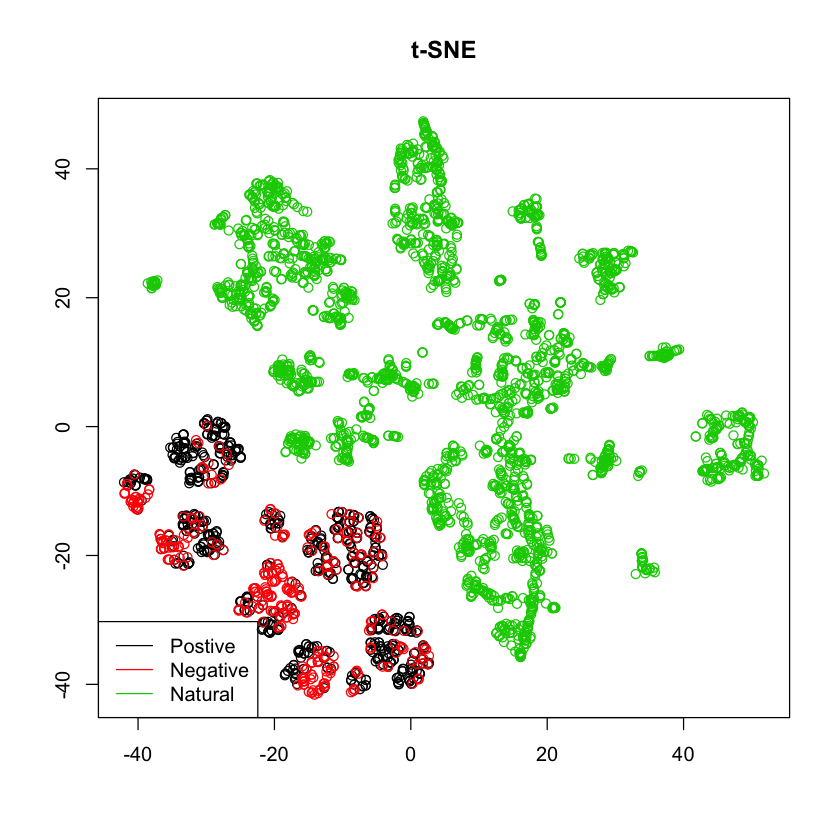

In [8]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot(tsne$Y, col = colors, xlab = "", ylab = "", main = "t-SNE")
legend("bottomleft", col = 1:3, legend = c("Postive", "Negative", "Natural"), lty = 1)

# Parallel Coordinate Plots

## Raw

y axis: Amino Acid (integer coded)  
x axis: Sequence position

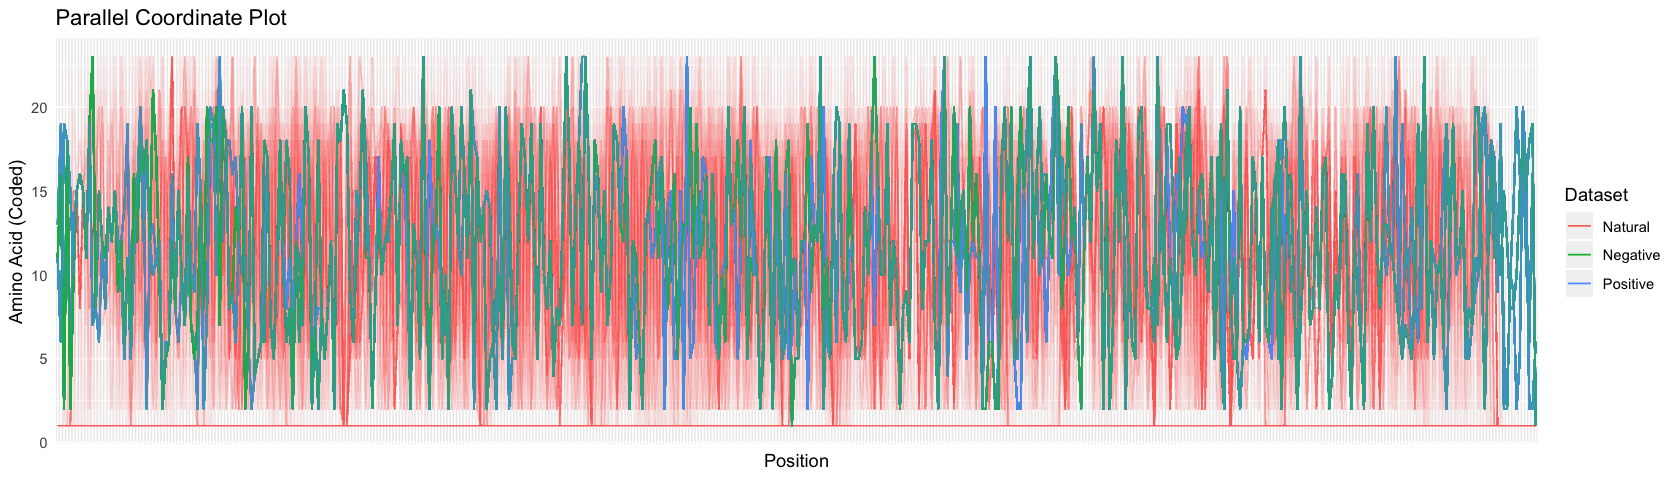

In [5]:
# Standarizing data matrix and sampling
AAs = c("-", "A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N",
           "P", "Q", "R", "S", "T", "V", "W", "X", "Y")
comb.std = comb
comb.std[] = lapply(comb.std, factor, levels = AAs)
comb.group.std = sample_n(cbind(labels, comb.std), size = 800)

# Mapping Transparencies (alphas)
alpha.map = c("Natural" = 0.01, "Positive" = 0.4, "Negative" = 0.4)
alphas = alpha.map[as.character(comb.group.std$labels)]
alphas.seq = rep(alphas, each = ncol(comb.group.std) - 1)

# Plotting
options(repr.plot.width = 14, repr.plot.height = 4)
pc = ggparcoord(comb.group.std, columns = 2:ncol(comb.group.std), groupColumn = 1,
                alpha = alphas.seq, scale = "globalminmax") + 
    ggtitle("Parallel Coordinate Plot") + xlab("Position") + 
    ylab("Amino Acid (Coded)") + labs(color = "Dataset") + 
    theme(axis.text.x = element_blank(), axis.ticks = element_blank())
plot(pc)

## Ordered

y axis: integer-coded amino acid, but the amino acid code order varies for each sequence position. They are for the negative/positive levels at the bottom, then the alphabetical natural levels above.  
x axis: Sequence position

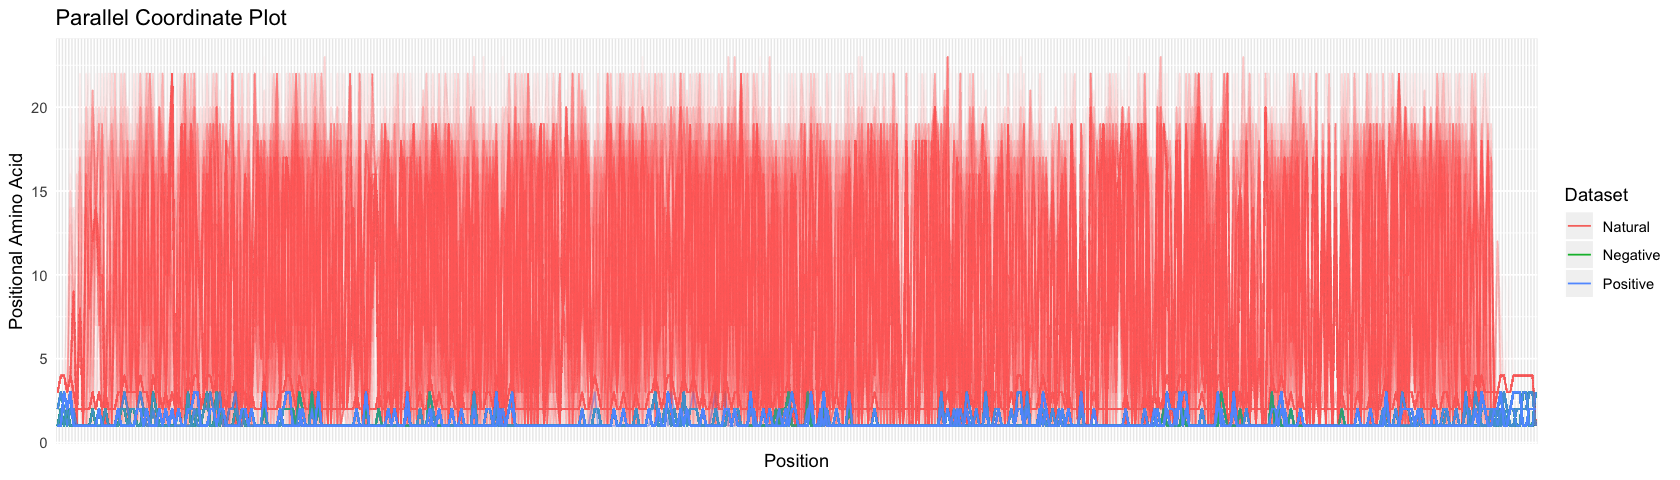

In [6]:
# Subsampling
comb.group = sample_n(cbind(labels, comb), size = 800)

# Mapping transparencies (alphas)
alpha.map = c("Natural" = 0.025, "Positive" = 0.6, "Negative" = 0.6)
alphas = alpha.map[as.character(comb.group$labels)]
alphas.seq = rep(alphas, each = ncol(comb.group) - 1)

# Plotting
options(repr.plot.width = 14, repr.plot.height = 4)
pc = ggparcoord(comb.group, columns = 2:ncol(comb.group), groupColumn = 1,
                alpha = alphas.seq, scale = "globalminmax") + 
    ggtitle("Parallel Coordinate Plot") + xlab("Position") + 
    ylab("Positional Amino Acid") + labs(color = "Dataset") + 
    theme(axis.text.x = element_blank(), axis.ticks = element_blank())
plot(pc)

# Naive Bayes

In [11]:
#### Forming classifier data ####
n.min = min(sum(positives), floor(0.5*sum(!positives)))
samples = c(sample(which(labels == "Positive"), n.min),
            sample(which(labels == "Negative"), 2*n.min),
            sample(which(labels == "Natural"), n.min))
bin.labels = as.factor(c(rep("Pos+Nat", nrow(eng.pos)),
                         rep("Neg", nrow(eng.neg)),
                         rep("Pos+Nat", nrow(nat.sub))))[samples]
true.labels.bin = c(rep("Positive", n.min), rep("Negative", 2*n.min),
                    rep("Natural", n.min))
classifier.data = cbind(bin.labels, comb[samples, ])
cat(n.min, "positives,", n.min, "naturals,", 2*n.min, "negatives.\n")

#### Cross validated Accuracy Estimate ####
folds = createFolds(classifier.data$bin.labels, k = 10)
test.acc = numeric(length(folds))
pos.acc = numeric(length(folds))
nat.acc = numeric(length(folds))
neg.acc = numeric(length(folds))
for (i in 1:length(folds)) {
    fold = folds[[i]]
    train = classifier.data[-fold, ]
    test = classifier.data[fold, ]
    NB = naiveBayes(bin.labels ~ ., data = train)
    preds = predict(NB, test, type = "class")
    test.acc[i] = mean(preds == test$bin.labels)
    fold.positives = true.labels.bin[fold] == "Positive"
    fold.naturals = true.labels.bin[fold] == "Natural"
    fold.negatives = true.labels.bin[fold] == "Negative"
    pos.acc[i] = mean((preds == test$bin.labels)[fold.positives])
    nat.acc[i] = mean((preds == test$bin.labels)[fold.naturals])
    neg.acc[i] = mean((preds == test$bin.labels)[fold.negatives])
}
cat("Overall 10-fold CV Accuracy =", mean(test.acc), "\n")
cat("Positive 10-fold CV Accuracy =", mean(pos.acc), "\n")
cat("Negative 10-fold CV Accuracy =", mean(neg.acc), "\n")
cat("Natural 10-fold CV Accuracy =", mean(nat.acc), "\n")

165 positives, 165 naturals, 330 negatives.
Overall 10-fold CV Accuracy = 0.75 
Positive 10-fold CV Accuracy = 0 
Negative 10-fold CV Accuracy = 1 
Natural 10-fold CV Accuracy = 1 
